# SWI - single layer

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import flopy.modflow as mf
import flopy.utils as fu
import matplotlib.pyplot as plt

## Paths

In [2]:
os.chdir('C:\\Users\\Bas\\Google Drive\\USGS\\FloPy\\slope1D')
sys.path.append('C:\\Users\\Bas\\Google Drive\\USGS\\FloPy\\basScript') # location of gridObj

modelname 	= 'run1swi2'
exe_name 	= 'mf2005'
workspace 	= 'data'

## Model input

In [3]:
ml = mf.Modflow(modelname, exe_name=exe_name, model_ws=workspace)

### Test variables

In [4]:
tscale = 365.*2000
nstp 	= tscale/100. 			#[]
perlen 	= tscale*1.	#[d]
ssz 	= 0.2 			#[]
Q 		= 0.01 	 	#[m3/d]

### Discretization data

In [5]:
nlay = 1
nrow = 1
ncol = 5
delr = 1.
delc = 1.
dell = 1.

top = np.array([[-1.,-1.,-1., -0.7, -0.4]], dtype = np.float32)
bot = np.array(top-dell, dtype = np.float32).reshape((nlay,nrow,ncol))
initWL = 0. # inital water level

### BCN: WEL

In [6]:
lrcQ1 = np.recarray(1, dtype = mf.ModflowWel.get_default_dtype())
lrcQ1[0] = (0, 0, 4, Q) #LRCQ, Q[m**3/d]

### BCN: GHB

In [7]:
lrchc = np.recarray(1, dtype = mf.ModflowGhb.get_default_dtype())
lrchc[0]=(0, 0, 0, -top[0,0]*0.025, 0.8 / 2.0 * delc)
lrchc[0]=(0, 0, 1, -top[0,0]*0.025, 0.8 / 2.0 * delc)
lrchc[0]=(0, 0, 2, -top[0,0]*0.025, 0.8 / 2.0 * delc)

### SWI2

In [8]:
#zini 	= bot[0,:,:]*-1.5
zini = -2.*np.ones((nrow,ncol))
#zini=bot
isource = np.array([[-2,2,-2, 0, 0]])
print zini.shape, isource.shape


(1L, 5L) (1L, 5L)


### Model objects

In [9]:
ml = mf.Modflow(modelname, version='mf2005', exe_name=exe_name)
discret = mf.ModflowDis(ml, nrow=nrow, ncol=ncol, nlay=nlay, delr=delr, delc=delc,
                        laycbd=[0], top=top, botm=bot,
                        nper=1, perlen=perlen, nstp=nstp)
bas = mf.ModflowBas(ml, ibound=1, strt=1.0*0.025)
bcf = mf.ModflowBcf(ml, laycon=[0], tran=[4.0])
wel = mf.ModflowWel(ml, stress_period_data={0:lrcQ1})
ghb = mf.ModflowGhb(ml, stress_period_data={0:lrchc})
swi = mf.ModflowSwi2(ml, nsrf=1, istrat=1, toeslope=0.02, tipslope=0.04, nu=[0, 0.025],
                     zeta=[zini], ssz=ssz, isource=isource, nsolver=1)
oc  = mf.ModflowOc(ml, save_head_every=nstp)
pcg = mf.ModflowPcg(ml)

In [10]:
ml.write_input() #--write the model files

## Run the model

In [11]:
m = ml.run_model(silent=True, report=True)

## Read the output

only one head entry and one zeta entry in binary files

In [12]:
headfile = modelname + '.hds'
hdobj = fu.HeadFile(headfile)
head = hdobj.get_data(idx=0)

In [13]:
zetafile = modelname + '.zta'
zobj = fu.CellBudgetFile(zetafile)
zeta = zobj.get_data(idx=0, text='      ZETASRF  1')[0]

## Plot

In [14]:
import gridobj as grd
gr = grd.gridobj(discret)
print zini
print 'head:    ', head[0, 0, :]
print 'BGH head: ', - 40. * (head[0, 0, :])

[[-2. -2. -2. -2. -2.]]
head:     [ 0.05    0.05    0.05    0.0525  0.055 ]
BGH head:  [-2.         -2.         -2.         -2.10000014 -2.20000005]


-1.5
-0.200000047684


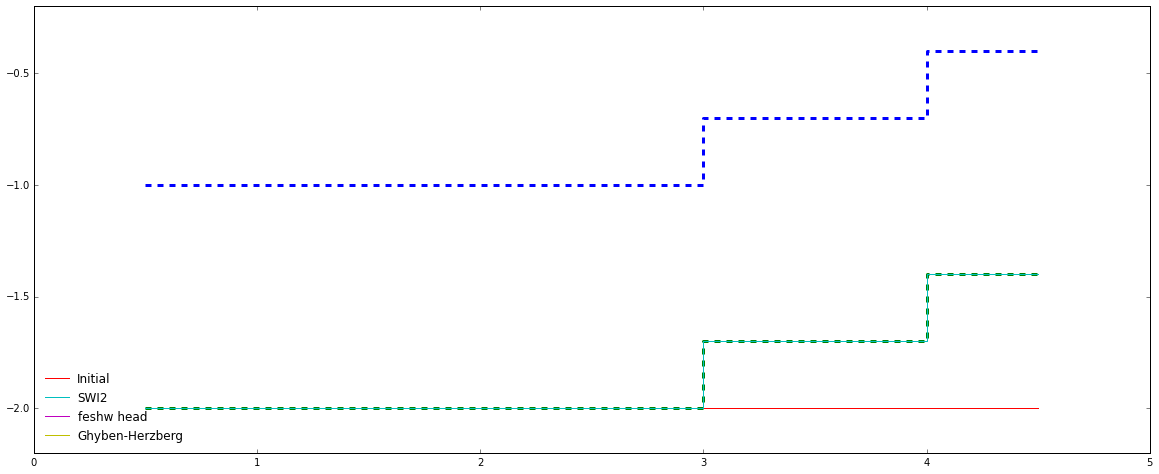

In [15]:
fig = plt.figure(figsize=(20, 8), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.plot(gr.cm,top.squeeze(),drawstyle='steps-mid', linestyle='--', linewidth=3. )
ax.plot(gr.cm,bot.squeeze(),drawstyle='steps-mid', linestyle='--', linewidth=3. )
ax.plot(gr.cm,zini[0,:], drawstyle='steps-mid',label='Initial')
ax.plot(gr.cm,zeta[0,0,:],drawstyle='steps-mid', label='SWI2')
ax.plot(gr.cm,head[0, 0, :], label='feshw head')
ax.plot(gr.cm,top[0.0]- 40. * (head[0, 0, :]), label='Ghyben-Herzberg')


ax.axis(gr.limLC([0,0,-0.2,0.2]))
leg = ax.legend(loc='lower left', numpoints=1)
leg._drawFrame = False

print np.sum(zeta[0,0,:3])+4.5
print np.sum(zeta[0,0,3:4])+1.5

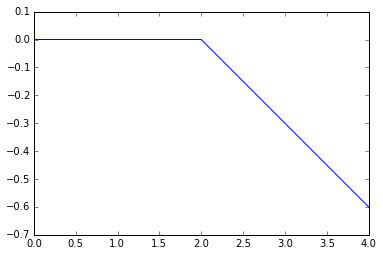

In [16]:
plt.plot(gr.cGr[0,:-1],zini[0,:]-zeta[0,0,:])